In [1]:
import pickle, os
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import cellrank as cr

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

from veloproj import *

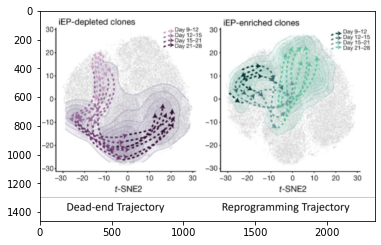

In [2]:
# figure from "Biddy, B.A., Kong, W., Kamimoto, K. et al. Single-cell mapping of lineage and identity in direct reprogramming. Nature 564, 219–224 (2018)."
# This Complex dataset has two trajectories.

img = mpimg.imread('./bi-trajectory.png')
imgplot = plt.imshow(img)
plt.show()

In [3]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-6', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'reprogramming_model.cpt',
                               '--exp-name', 'CohAE_reprogramming',
                               '--device', 'cuda:1',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', 'SU',
                               '--ld_nb_g_src', 'X',
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'pseudotime',
                               '--scv_n_jobs', '10',
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir=None, device='cuda:1', exp_name='CohAE_reprogramming', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=5.0, h_dim=256, is_half=False, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='X', log_interval=100, lr=1e-06, lr_decay=0.9, mask_cluster_list=None, model_name='reprogramming_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='SU', output='./', refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=0.0, vis_key='X_umap', vis_type_col='pseudotime', weight_decay=0.0, z_dim=100)

In [4]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [5]:
cluster_edges = [('2', '6'),('5','6'),('6', '1'), # rerogramming trajectory
                  ('5', '2'),('2','8'),('8', '7'),('7','4'),('4','3'),('3', '0') # Dead end trajectory
                 ]
EXP_NAME = args.exp_name
exp_metrics = {}

In [6]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device, is_half=args.is_half)
    return tensor_s, tensor_u, tensor_x  

In [7]:
adata = cr.datasets.reprogramming_morris()
adata = adata[~adata.obs.cell_type.isna()]
adata = adata[~adata.obs.monocle_state.isna()]
sel = ~adata.obs.reprogramming_day.isna()
sel = sel & np.array(np.isnan(adata.obsm['X_tsne']).sum(axis=1) == 0)
adata = adata[sel].copy()
adata.obsm['X_umap'] = adata.obsm['X_tsne']
adata.obs.cluster = adata.obs.cluster.astype(str)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.71 0.29]
AnnData object with n_obs × n_vars = 32717 × 2000
    obs: 'timecourse', 'reprogramming_day', 'reprogramming', 'cell_type', 'cell_cycle', 'cluster', 'monocle_state', 'pseudotime', 'CellTagD0_85k', 'CellTagD3_85k', 'CellTagD13_85k', 'CellTagD0_48k', 'CellTagD3_48k', 'CellTagD13_48k', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'cell_cycle_colors', 'cluster_colors', 'reprogramming_colors', 'reprogramming_day_colors', 'pca', 'neighbors'
    obsm: 'X_diff', 'X_tsne', 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


  0%|          | 0/32717 [00:00<?, ?cells/s]

/data/users/cqiao/.conda_envs/veloAE/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


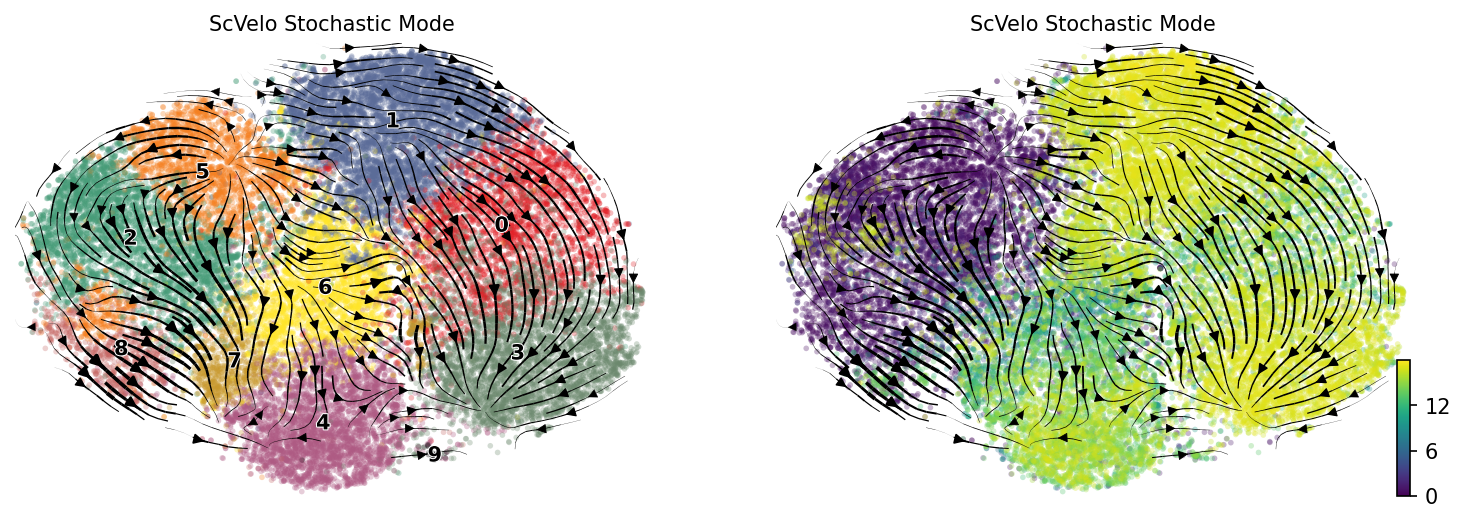

# Cross-Boundary Transition Score (A->B)
{('2', '6'): 0.08593346, ('5', '6'): 0.074677676, ('6', '1'): 0.08014734, ('5', '2'): 0.08526913, ('2', '8'): 0.052067325, ('8', '7'): 0.11021785, ('7', '4'): 0.09219596, ('4', '3'): 0.107589774, ('3', '0'): 0.10613036}
Total Mean: 0.08824765682220459
# Cross-Boundary Velocity Coherence (A->B)
{('2', '6'): 0.8298227, ('5', '6'): 0.8468888, ('6', '1'): 0.777729, ('5', '2'): 0.8470944, ('2', '8'): 0.83327097, ('8', '7'): 0.813189, ('7', '4'): 0.744017, ('4', '3'): 0.76234525, ('3', '0'): 0.71169454}
Total Mean: 0.7962279915809631
# Cross-Boundary Direction Correctness (A->B)
{('2', '6'): 0.3727031353490629, ('5', '6'): 0.07356780274886594, ('6', '1'): 0.03754214414531245, ('5', '2'): 0.19986273979531463, ('2', '8'): 0.1189417932365129, ('8', '7'): 0.5021428113308458, ('7', '4'): 0.4043823419172911, ('4', '3'): 0.16207577721603486, ('3', '0'): -0.2739702125961492}
Total Mean: 0.17747203701589906
# In-cluster Coherence
{'0': 0.762878, '1': 0.7781232

In [8]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                vkey="stc_velocity", 
                                basis=args.vis_key,
                                color=['cluster', args.vis_type_col],
                                dpi=150, 
                                save="reprogramming_stc.png",
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, 'cluster', "stc_velocity")

Loss: (Total) 9.533073, (AE) 9.458473, (LR) 1.00 * 0.074601: 100%|██████████| 20000/20000 [1:02:11<00:00,  5.36it/s] 


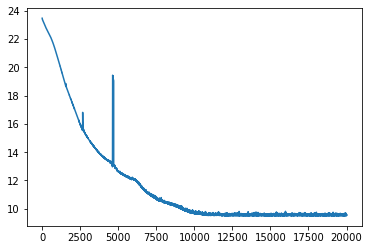

In [9]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

  0%|          | 0/32717 [00:00<?, ?cells/s]

/data/users/cqiao/.conda_envs/veloAE/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


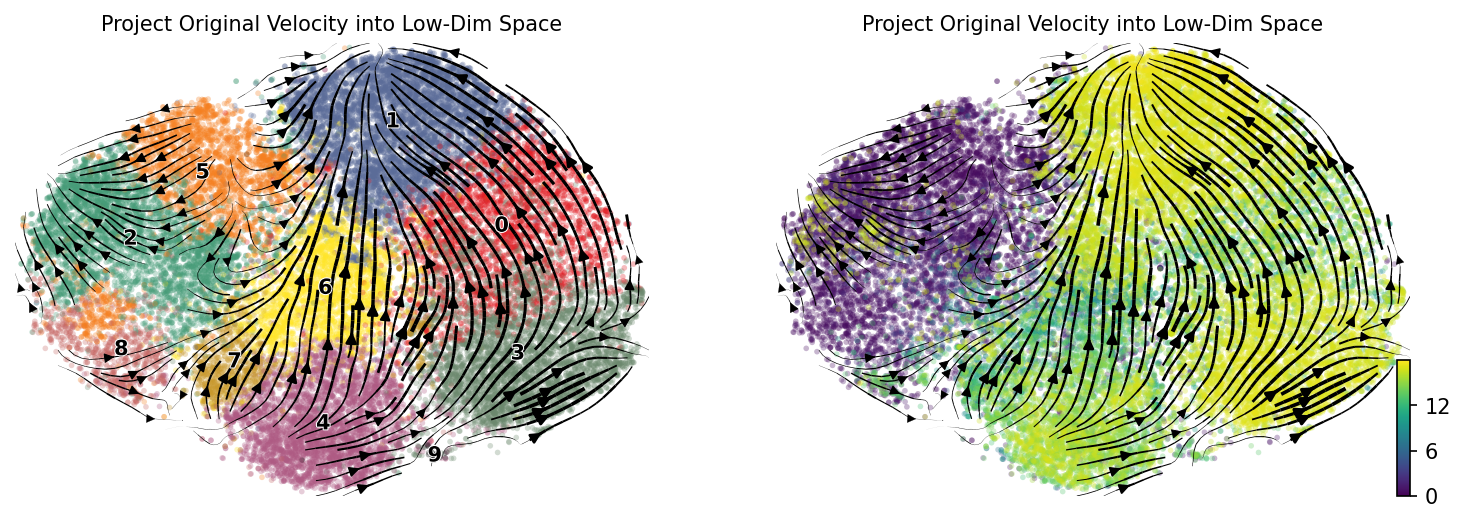

# Cross-Boundary Transition Score (A->B)
{('2', '6'): 0.57111573, ('5', '6'): 0.521341, ('6', '1'): 0.71366554, ('5', '2'): 0.53176624, ('2', '8'): 0.38772297, ('8', '7'): 0.43596628, ('7', '4'): 0.3655186, ('4', '3'): 0.4614724, ('3', '0'): 0.61544967}
Total Mean: 0.5115575790405273
# Cross-Boundary Velocity Coherence (A->B)
{('2', '6'): 0.9999078, ('5', '6'): 0.99989855, ('6', '1'): 0.9999141, ('5', '2'): 0.9999336, ('2', '8'): 0.9999245, ('8', '7'): 0.99990636, ('7', '4'): 0.9999253, ('4', '3'): 0.99994296, ('3', '0'): 0.99995226}
Total Mean: 0.9999228715896606
# Cross-Boundary Direction Correctness (A->B)
{('2', '6'): -0.10113990352186815, ('5', '6'): 0.06343564278173963, ('6', '1'): 0.754229610757503, ('5', '2'): 0.20872275889129727, ('2', '8'): -0.13356086250438817, ('8', '7'): 0.5020857413093276, ('7', '4'): -0.2745720879607368, ('4', '3'): 0.545400436145175, ('3', '0'): 0.365239186722838}
Total Mean: 0.21442672473565413
# In-cluster Coherence
{'0': 0.99995506, '1': 0.99993217, 

In [10]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=args.scv_n_jobs)
    scv.pl.velocity_embedding_stream(adata,
                                    vkey="new_velocity", basis=args.vis_key, color=['cluster', args.vis_type_col],
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=150,
                                    save='reprogramming_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, 'cluster', "new_velocity")
exp(adata, exp_metrics)

  0%|          | 0/1426 [00:00<?, ?gene/s]

/data/users/cqiao/.conda_envs/veloAE/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/data/users/cqiao/.conda_envs/veloAE/lib/python3.7/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


  0%|          | 0/32717 [00:00<?, ?cells/s]

/data/users/cqiao/.conda_envs/veloAE/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


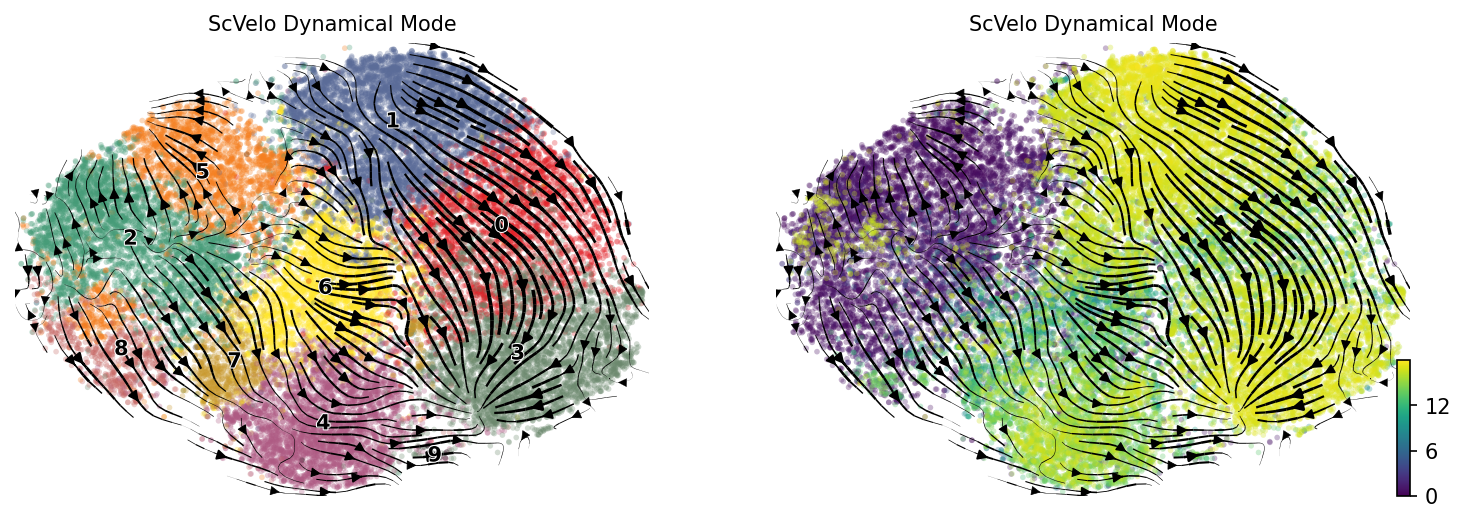

# Cross-Boundary Transition Score (A->B)
{('2', '6'): 0.1851588, ('5', '6'): 0.16417024, ('6', '1'): 0.18691096, ('5', '2'): 0.19666125, ('2', '8'): 0.213577, ('8', '7'): 0.20521228, ('7', '4'): 0.19216082, ('4', '3'): 0.24373329, ('3', '0'): 0.11152742}
Total Mean: 0.1887902468442917
# Cross-Boundary Velocity Coherence (A->B)
{('2', '6'): 0.780692507319863, ('5', '6'): 0.7972539313227465, ('6', '1'): 0.9007365447712268, ('5', '2'): 0.7899044854788986, ('2', '8'): 0.8189610527841626, ('8', '7'): 0.8255397488387137, ('7', '4'): 0.9013466501609821, ('4', '3'): 0.8894913559800214, ('3', '0'): 0.919123685081888}
Total Mean: 0.8470055513042781
# Cross-Boundary Direction Correctness (A->B)
{('2', '6'): 0.051968380263580645, ('5', '6'): -0.2613787853525929, ('6', '1'): -0.2090430644802807, ('5', '2'): -0.11593398308906441, ('2', '8'): 0.04983911144324822, ('8', '7'): 0.3098546834885758, ('7', '4'): 0.3984735535772083, ('4', '3'): 0.31436081856919545, ('3', '0'): -0.3484075573257061}
Total Mea

In [11]:
scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                vkey="dyn_velocity", 
                                basis=args.vis_key, 
                                color=['cluster', args.vis_type_col],
                                dpi=150, 
                                title='ScVelo Dynamical Mode')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, 'cluster', "dyn_velocity")

In [12]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)